# Imports

In [1]:
import sys
sys.path.append("../lib")
import imageio.v2 as imageio
import os
import shutil
import em2d as zpic
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
import math
from IPython.display import Video
matplotlib.rcParams["figure.figsize"] = (12, 8)

# Noramalization in ZPIC

The normalization in ZPIC is done by choosing a reference normalization frequency, $\omega_n$. Using this, different units are noramlized by the formulae:
$$
\begin{align*}
x' &= \frac{\omega_n}{c} x\\
t' &= \frac{t}{\omega_n}\\
u' &= \frac{u}{c} = \frac{\gamma v}{c}\\
E' &= e \frac{c / \omega_n }{m_e c^2} E\\
B' &= e \frac{c / \omega_n }{m_e c^2} B
\end{align*}
$$

In the simulation, we will choose $\omega_n$ such as the plasma density is eqaul to $1$. This can be done by using the relation of plasma density:
$$
\omega_p = \sqrt{\frac{n_0e^2}{\epsilon_0 m}}
$$
Which simplifies to:
$$
\omega_p = 56.35\times \sqrt{n_0}
$$

# 6.1.1 Simulation of laser propagation in vacuum


## Parameters

### In Real Units

- Simulation Box: $20\:\mu m\times20\:\mu m\times50\:\mu m$
- Number of Cells: $200\times200\times500$
- Plasma Density: $n_0 = 10^{25} \: m^{-3}$
- Laser Intensity: $I = 2\times10^{22} \: Wm^{-2}$
- Laser Wavelength: $\lambda = 10^{-6} \: m$
- Particle Per Cell: $0$
- FWHM of the Laser: $1 \:\mu m$
- Width of the Laser: $2.5 \:\mu m$
- The laser propagates in z direction and is p-polarized, that is, the electric field vector of the laser oscillates along the y-axis.
- The laser starts at $(10\:\mu m\times10\:\mu m\times-2\:\mu m)$ which is the center of the xy-plane $2 \:\mu m$ in front of the
simulation box.

### In Simulation Units

As $n_0=10^{25} \: m^{-3}$, the electron plasma frequency corresponding to this is 
$$
\begin{align*}
\omega_n &= 56.35\times \sqrt{10^{25}} \: \mathrm{Hz}\\
&= 1.78\times 10^{14} \: \mathrm{Hz}
\end{align*}
$$

Using this we can calculate that $1 \:\mu m$ is equal to $0.593 \: \text{zpic unit}$

Now, the electric field of the laser is can be calculated using:
$$
I = \frac{1}{2}\epsilon_0 c E_0^2
$$
The electric field comes out to be $3.882\times 10^{12} \:\text{N/C}$. Noramlizing this to ZPIC unit gives a value of $12.77$.

Next, we'll calculate the frequency of the laser using its wavelength. Since $f = \frac{c}{\lambda}$, the frequency is (after multiplying with $2\pi$) $1.88\times 10^{15} \:\text{Hz}$. In ZPIC units, this is equal to $10.6$.

The laser propagates in z direction and is p-polarized, however, ZPIC supports only those lasers moving in x direction. Hence, we'll be changing the axes such that:

z -> x

x -> y

y -> z

In this way, the laser in propagating in x direction while the electric field vector of the laser oscillates along the z-axis, making an angle of $\pi/2$ with y-axis.

The final units are:
- Simulation Box: $12 \times12 \times30$
- Number of Cells: $200\times200\times500$
- Plasma Density `n0`: $1$
- Particle Per Cell `ppc`: $0$
- Normalized vector potential `a0`: $12.77$
- Laser frequency `omega0` : $10.6$
- FWHM of the Laser `fwhm`  : $0.593$
- Width of the Laser `W0`: $1.48$
- Laser polarization in radians measured in reference to the y direction `polarization`: $\pi/2$

## Simulation

In [2]:
((30/500)**2+(12/200)**2)**0.5

0.08485281374238571

In [3]:
box = [30.0, 12.0]
dt = 0.01
ppc = [0,0]
nx  = [ 500, 200 ]
tmax = 24.9
sim = zpic.Simulation( nx, box, dt)

In [4]:
sim.add_laser( zpic.Laser( type = "gaussian", start = 2, fwhm = 0.593, a0 = 12.77, omega0 = 10.6, 
                           W0 = 1.48, polarization = np.pi/2 ))

In [5]:
tdump = 100
max_time = math.ceil(tmax/(dt*tdump))
ezs = np.zeros((max_time, nx[1], nx[0]))
rhos = np.zeros((max_time, nx[1], nx[0]))
times = ["1.00", "6.00", "8.40", "12.00", "18.00", "23.60"]
ezs_time = np.zeros((len(times), nx[1], nx[0]))
rhos_time = np.zeros((len(times), nx[1], nx[0]))
j = 0
for t in range(int(tmax/dt)):
    print(f"t = {t*dt:.2f} of {tmax}", end = "\r")
    sim.iter()
    if t % tdump == 0:
        ezs[t//tdump,:,:] = sim.emf.Ez_part
    if f"{t*dt:.2f}" in times:
        ezs_time[j,:,:] = sim.emf.Ez_part
        j += 1

In [15]:
time_new = np.linspace(0, tmax, max_time)
time_new

array([ 0.    ,  1.0375,  2.075 ,  3.1125,  4.15  ,  5.1875,  6.225 ,
        7.2625,  8.3   ,  9.3375, 10.375 , 11.4125, 12.45  , 13.4875,
       14.525 , 15.5625, 16.6   , 17.6375, 18.675 , 19.7125, 20.75  ,
       21.7875, 22.825 , 23.8625, 24.9   ])

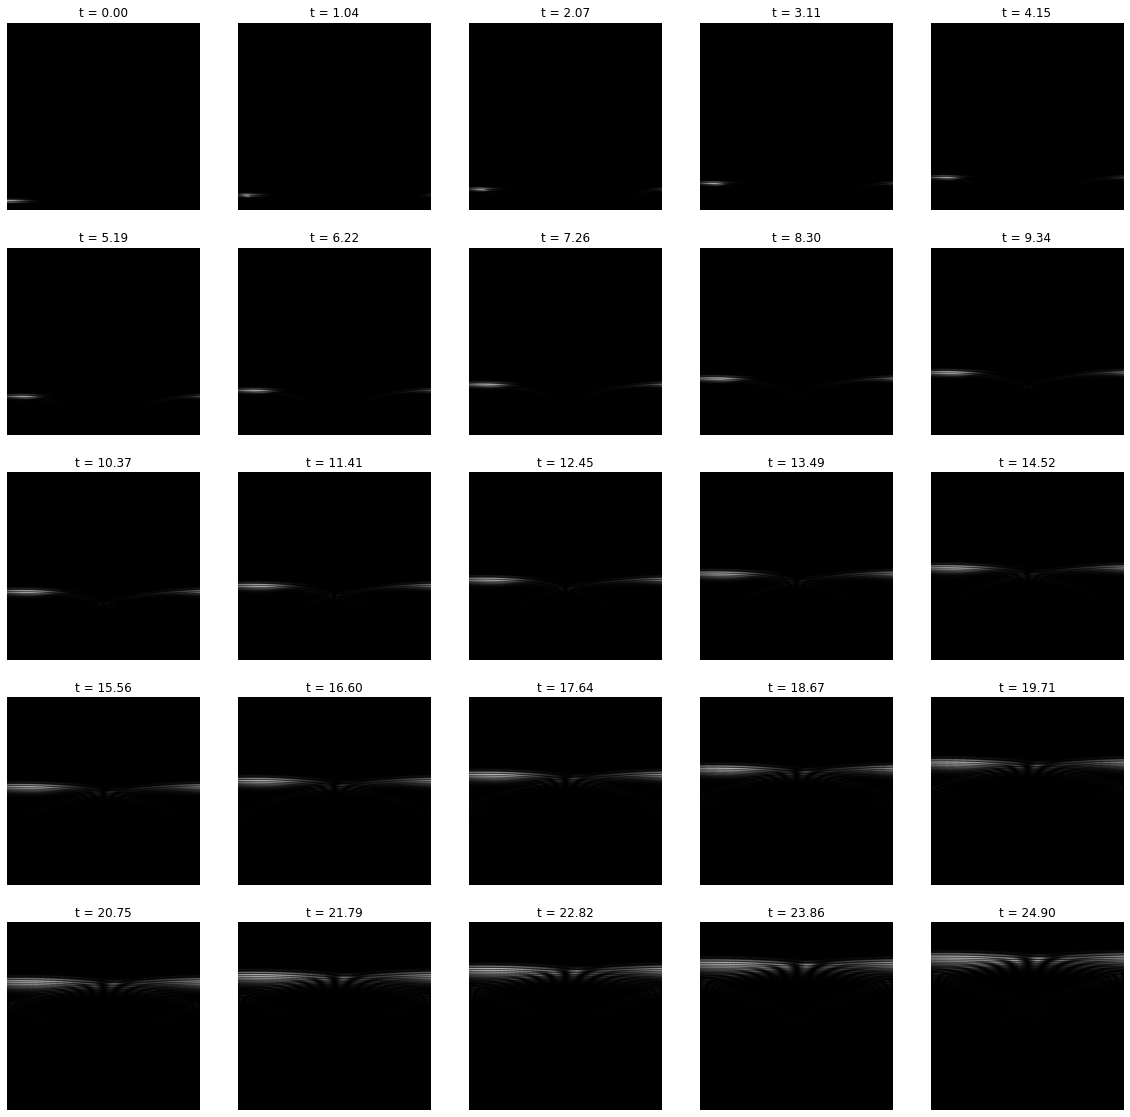

In [22]:
fig, axs = plt.subplots(5,5)
fig.set_size_inches(20,20)
time_new = np.linspace(0, tmax, max_time)
boundary = [[0,sim.box[0]],[0,sim.box[1]]]
for i in range(25):
    row = i//5
    col = i%5
    ax = axs[row,col]
    ax.imshow( ezs[i].T**2, interpolation = 'bilinear', origin = 'lower',
            extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
            aspect = 'auto', cmap = 'gray')
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_title(f"t = {time_new[i]:.2f}")
    ax.axis('off')


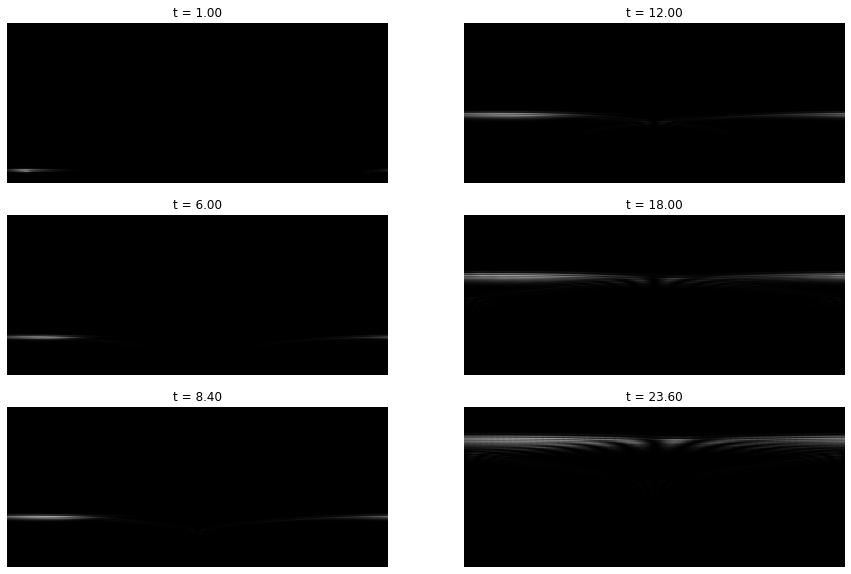

In [25]:
fig, axs = plt.subplots(3,2)
fig.set_size_inches(15,10)
time_new = np.linspace(0, tmax, max_time)
boundary = [[0,sim.box[0]],[0,sim.box[1]]]
for i in range(6):
    row = i//3
    col = i%3
    ax = axs[col,row]
    ax.imshow( ezs_time[i].T**2, interpolation = 'bilinear', origin = 'lower',
            extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
            aspect = 'auto', cmap = 'gray')
            # plt.colorbar().set_label('$E_z$')
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_title(f"t = {times[i]}")
    ax.axis('off')


In [91]:
def plot_per_time(time):
    boundary = [[0,sim.box[0]],[0,sim.box[1]]]

    plt.imshow( ezs_time[time].T**2, interpolation = 'bilinear', origin = 'lower',
            extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
            aspect = 'auto', cmap = 'gray')

    plt.colorbar().set_label('$E_z$')
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title(f"Laser Field\nt = {times[time]}")

    plt.show()

# 6.1.2 Simulations of relativistic self-focusing in 2D

## Parameters

### In Real Units

- Simulation Box: $40\:\mu m\times40\:\mu m\times50\:\mu m$
- Number of Cells: $400\times400\times1000$
- Plasma Density: $n_0 = 10^{26} \: m^{-3}$
- Laser Intensity: $I = 10^{23} \: Wm^{-2}$
- Laser Wavelength: $\lambda = 10^{-6} \: m$
- Particle Per Cell: $2$
- FWHM of the Laser: $1 \:\mu m$
- Width of the Laser: $5 \:\mu m$
- The laser propagates in z direction and is s-polarized, that is, the electric field vector of the laser oscillates in the x axis.
- The laser starts at $(20\:\mu m\times20\:\mu m\times-2\:\mu m)$ which is the center of the xy-plane $2 \:\mu m$ in front of the
simulation box.

### In Simulation Units

As $n_0=10^{25} \: m^{-3}$, the electron plasma frequency corresponding to this is 
$$
\begin{align*}
\omega_n &= 56.35\times \sqrt{10^{26}} \: \mathrm{Hz}\\
&= 5.635\times 10^{14} \: \mathrm{Hz}
\end{align*}
$$

Using this we can calculate that $1 \:\mu m$ is equal to $1.88 \: \text{zpic unit}$

Now, the electric field of the laser is can be calculated using:
$$
I = \frac{1}{2}\epsilon_0 c E_0^2
$$
The electric field comes out to be $8.680\times 10^{12} \:\text{N/C}$. Noramlizing this to ZPIC unit gives a value of $9.03$.

Next, we'll calculate the frequency of the laser using its wavelength. Since $f = \frac{c}{\lambda}$, the frequency is (after multiplying with $2\pi$) $1.88\times 10^{15} \:\text{Hz}$. In ZPIC units, this is equal to $3.345$.

The laser propagates in z direction and is s-polarized, however, ZPIC supports only those lasers moving in x direction. Hence, we'll be changing the axes such that:

z -> x

x -> y

y -> z

In this way, the laser in propagating in x direction while the electric field vector of the laser oscillates along the y-axis, making an angle of $0$ with y-axis.

The final units are:
- Simulation Box: $75 \times75 \times94$
- Number of Cells: $400\times400\times1000$
- Plasma Density `n0`: $1$
- Particle Per Cell `ppc`: $2$
- Normalized vector potential `a0`: $9.03$
- Laser frequency `omega0` : $3.345$
- FWHM of the Laser `fwhm`  : $1.878$
- Width of the Laser `W0`: $9.39$
- Laser polarization in radians measured in reference to the y direction `polarization`: $0$

## Simulation

In [1]:
((75/400)**2+(94/1000)**2)**0.5

0.20974329548283538

In [6]:
import sys
sys.path.append("../lib")
import em2d as zpic
box = [94.0, 75.0]
dt = 0.05
ppc = [2,2]
nx  = [ 1000, 400 ]
tmax = 24.9*2
electrons = zpic.Species( "electrons", -1.0, ppc,
                           density = zpic.Density( type = "uniform", n = 1 ) )

protons = zpic.Species( "protons", 1836, ppc,
                           density = zpic.Density( type = "uniform", n = 1 ) )
sim = zpic.Simulation( nx, box, dt, species=[electrons, protons] )

In [7]:
sim.add_laser( zpic.Laser( type = "gaussian", start = 2, fwhm = 1.878, a0 = 9.03, omega0 = 3.345, 
                           W0 = 9.39, polarization = 0 ))

In [32]:
tdump = int(1/dt)*2
max_time = math.ceil(tmax/(dt*tdump))
ezs = np.zeros((max_time, nx[1], nx[0]))
eys = np.zeros((max_time, nx[1], nx[0]))
exs = np.zeros((max_time, nx[1], nx[0]))
rhos = np.zeros((max_time, nx[1], nx[0]))
times = ["1.00", "6.00", "8.40", "12.00", "18.00", "23.60"]
ezs_time = np.zeros((len(times), nx[1], nx[0]))
eys_time = np.zeros((len(times), nx[1], nx[0]))
exs_time = np.zeros((len(times), nx[1], nx[0]))
j = 0
for t in range(int(tmax/dt)):
    print(f"t = {t*dt:.2f} of {tmax}", end = "\r")
    sim.iter()
    if t % tdump == 0:
        ezs[t//tdump,:,:] = sim.emf.Ez_part
        eys[t//tdump,:,:] = sim.emf.Ey_part
        exs[t//tdump,:,:] = sim.emf.Ex_part
    if f"{t*dt:.2f}" in times:
        ezs_time[j,:,:] = sim.emf.Ez_part
        eys_time[j,:,:] = sim.emf.Ey_part
        exs_time[j,:,:] = sim.emf.Ex_part
        j += 1

In [33]:
time_new = np.linspace(0, tmax, max_time)
time_new

array([ 0.   ,  2.075,  4.15 ,  6.225,  8.3  , 10.375, 12.45 , 14.525,
       16.6  , 18.675, 20.75 , 22.825, 24.9  , 26.975, 29.05 , 31.125,
       33.2  , 35.275, 37.35 , 39.425, 41.5  , 43.575, 45.65 , 47.725,
       49.8  ])

In [11]:
boundary = [[0,sim.box[0]],[0,sim.box[1]]]
boundary

[[0, 94.0], [0, 75.0]]

In [30]:
ezs[0].shape

(400, 1000)

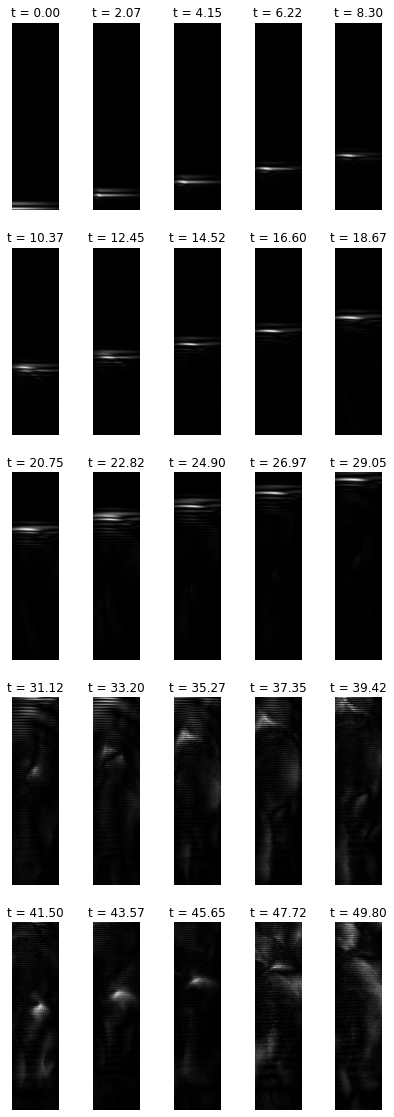

In [42]:
fig, axs = plt.subplots(5,5)
fig.set_size_inches(7,20)
time_new = np.linspace(0, tmax, max_time)
boundary = [[0,sim.box[0]],[0,sim.box[1]]]
for i in range(25):
    row = i//5
    col = i%5
    ax = axs[row,col]
    ax.imshow( eys[i][:50, :300].T**2, interpolation = 'bilinear', origin = 'lower',
            extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
            aspect=5, 
            cmap = 'gray')
            # plt.colorbar().set_label('$E_z$')
#     ax.set_xlabel("$x_1$")
#     ax.set_ylabel("$x_2$")
    ax.set_title(f"t = {time_new[i]:.2f}")
    ax.axis('off')


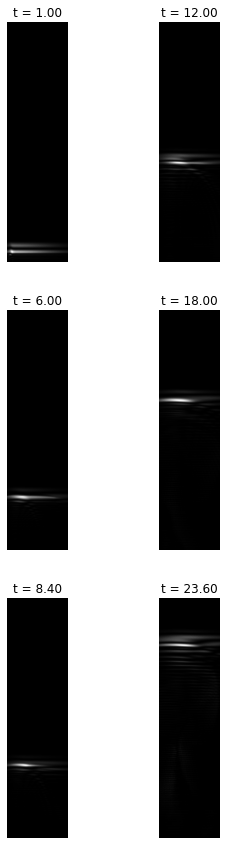

In [35]:
fig, axs = plt.subplots(3,2)
fig.set_size_inches(5,15)
time_new = np.linspace(0, tmax, max_time)
boundary = [[0,sim.box[0]],[0,sim.box[1]]]
for i in range(6):
    row = i//3
    col = i%3
    ax = axs[col,row]
    ax.imshow( eys_time[i][:50, :300].T**2, interpolation = 'bilinear', origin = 'lower',
            extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
            aspect = 5, cmap = 'gray')
            # plt.colorbar().set_label('$E_z$')
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_title(f"t = {times[i]}")
    ax.axis('off')


Text(0, 0.5, '$x_2$')

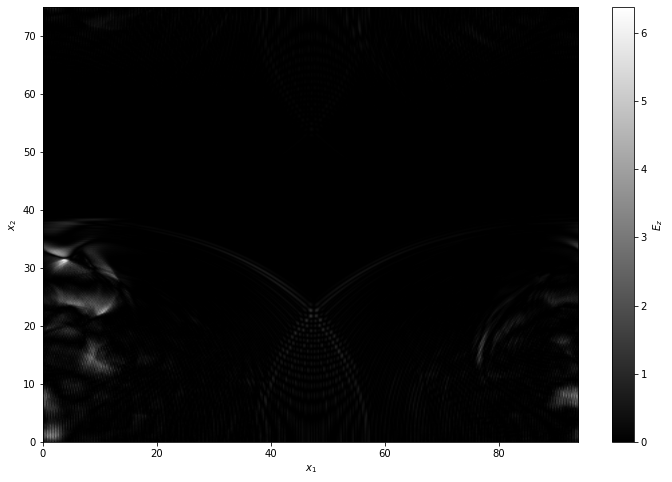

In [45]:
boundary = [[0,sim.box[0]],[0,sim.box[1]]]

plt.imshow( sim.emf.Ex.T**2, interpolation = 'bilinear', origin = 'lower',
        extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
        aspect = 'auto', cmap = 'gray')

plt.colorbar().set_label('$E_z$')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

In [10]:
def plot_per_time(time):
    boundary = [[0,sim.box[0]],[0,sim.box[1]]]

    plt.imshow( ezs_time[time].T**2, interpolation = 'bilinear', origin = 'lower',
            extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
            aspect = 'auto', cmap = 'gray')

    plt.colorbar().set_label('$E_z$')
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title(f"Laser Field\nt = {times[time]}")

    plt.show()

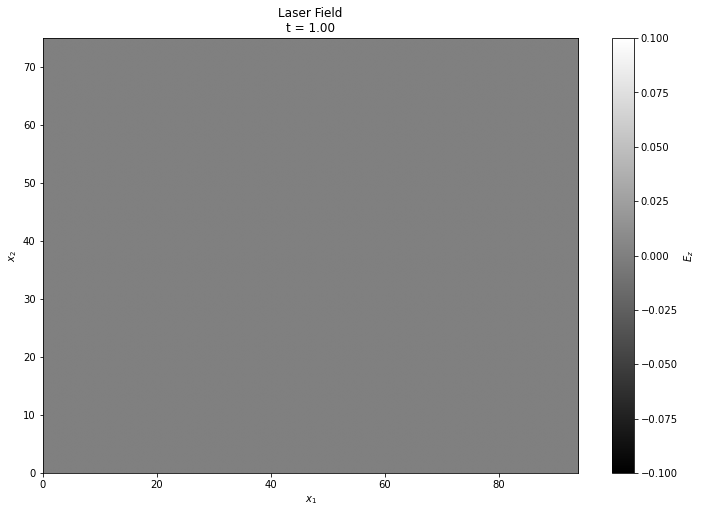

In [11]:
plot_per_time(0)

# Old Simulation

In [2]:
box = [12.0, 15.0]
# nx = [400, 1000]
dt = 0.01
ppc = [0,0]
# dt = 0.014
tmax = 18.1

#Simulation box
nx  = [ 360, 300 ]
# box = [ 20.0, 25.6 ]

electrons = zpic.Species( "electrons", -1.0, ppc,
                           density = zpic.Density( type = "uniform", n = 1 ) )

protons = zpic.Species( "protons", 1840, ppc,
                           density = zpic.Density( type = "uniform", n = 1 ) )
sim = zpic.Simulation( nx, box, dt, species=[electrons, protons] )

In [3]:
sim.add_laser( zpic.Laser( type = "gaussian", start = 5, fwhm = 0.3, a0 = 56.5, omega0 = 3.3, 
                           W0 = 1.5, polarization = np.pi/2 ))
# sim.set_moving_window()

In [4]:
ezs = np.zeros((19, nx[1], nx[0]))
rhos = np.zeros((19, nx[1], nx[0]))
ezs_time = np.zeros((4, nx[1], nx[0]))
rhos_time = np.zeros((4, nx[1], nx[0]))
tdump = 100
j = 0
times = ["6.00", "8.40", "12.00", "18.00"]
for t in range(int(tmax/dt)):
    print(f"t = {t*dt:.2f} of {tmax}", end = "\r")
    sim.iter()
    if t % tdump == 0:
        ezs[t//tdump,:,:] = sim.emf.Ez[:,:]
        rhos[t//tdump,:,:] = electrons.charge()[:,:]
        # ezs.append(sim.emf.Ez)
        # rhos.append(electrons.charge())
    if f"{t*dt:.2f}" in times:
        ezs_time[j,:,:] = sim.emf.Ez[:,:]
        rhos_time[j,:,:] = electrons.charge()[:,:]
        j += 1
        # ezs_time.append(sim.emf.Ez)
        # rhos_time.append(electrons.charge())

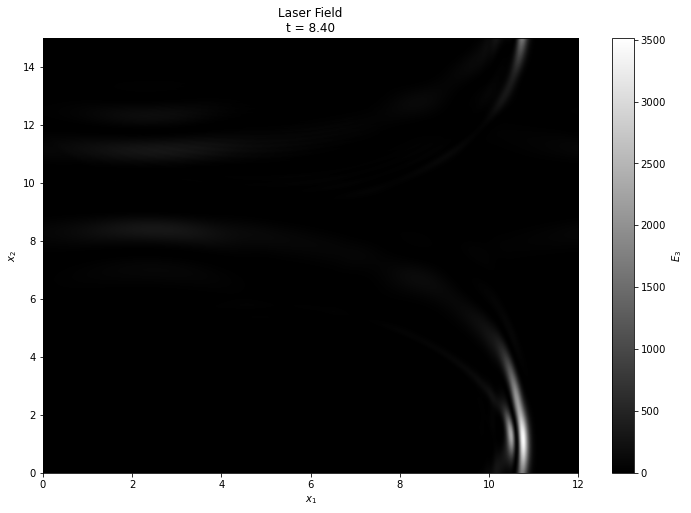

In [13]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

boundary = [[0,sim.box[0]],[0,sim.box[1]]]

plt.imshow( ezs_time[0]**2, interpolation = 'bilinear', origin = 'lower',
          extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
          aspect = 'auto', cmap = 'gray')

plt.colorbar().set_label('$E_3$')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Laser Field\nt = {}".format(times[1]))

plt.show()

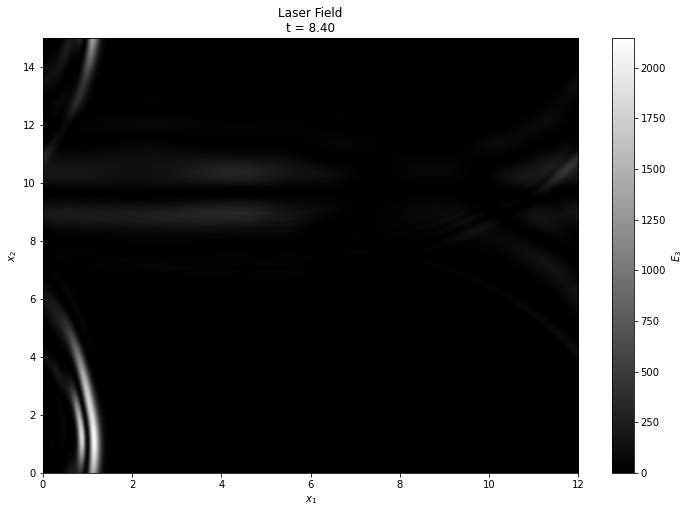

In [12]:
import matplotlib.pyplot as plt

boundary = [[0,sim.box[0]],[0,sim.box[1]]]

plt.imshow( ezs_time[1]**2, interpolation = 'bilinear', origin = 'lower',
          extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
          aspect = 'auto', cmap = 'gray')

plt.colorbar().set_label('$E_3$')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Laser Field\nt = {}".format(times[1]))

plt.show()

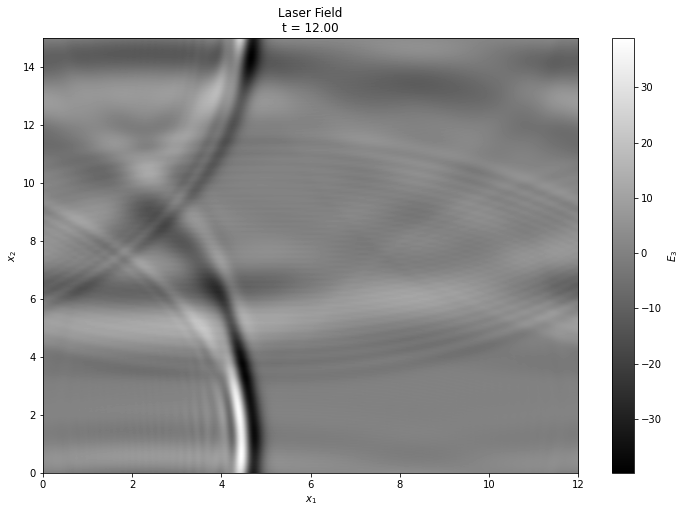

In [14]:
import matplotlib.pyplot as plt

boundary = [[0,sim.box[0]],[0,sim.box[1]]]

plt.imshow( ezs_time[2], interpolation = 'bilinear', origin = 'lower',
          extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
          aspect = 'auto', cmap = 'gray')

plt.colorbar().set_label('$E_3$')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Laser Field\nt = {}".format(times[2]))

plt.show()

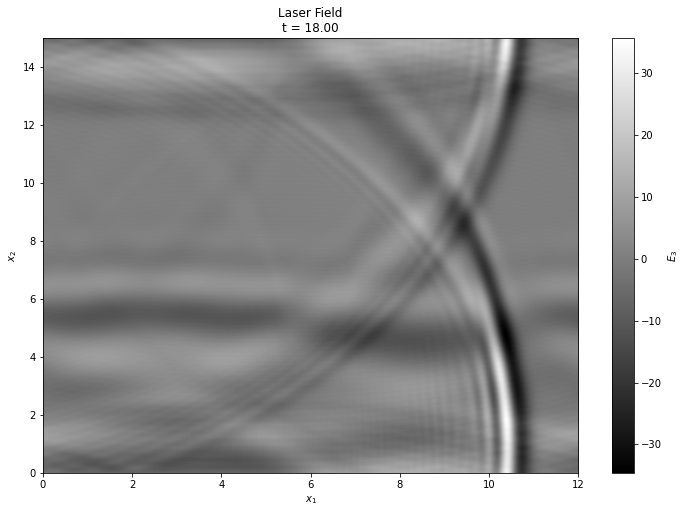

In [15]:
import matplotlib.pyplot as plt

boundary = [[0,sim.box[0]],[0,sim.box[1]]]

plt.imshow( ezs_time[3], interpolation = 'bilinear', origin = 'lower',
          extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
          aspect = 'auto', cmap = 'gray')

plt.colorbar().set_label('$E_3$')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Laser Field\nt = {}".format(times[3]))

plt.show()

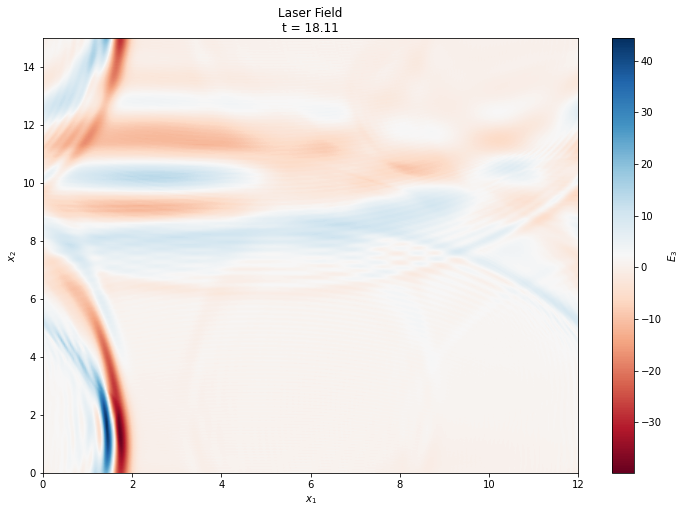

In [18]:
import matplotlib.pyplot as plt

boundary = [[0,sim.box[0]],[0,sim.box[1]]]

plt.imshow( ezs[-10], interpolation = 'bilinear', origin = 'lower',
          extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
          aspect = 'auto', cmap = 'RdBu')

plt.colorbar().set_label('$E_3$')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Laser Field\nt = {:g}".format(sim.t))

plt.show()

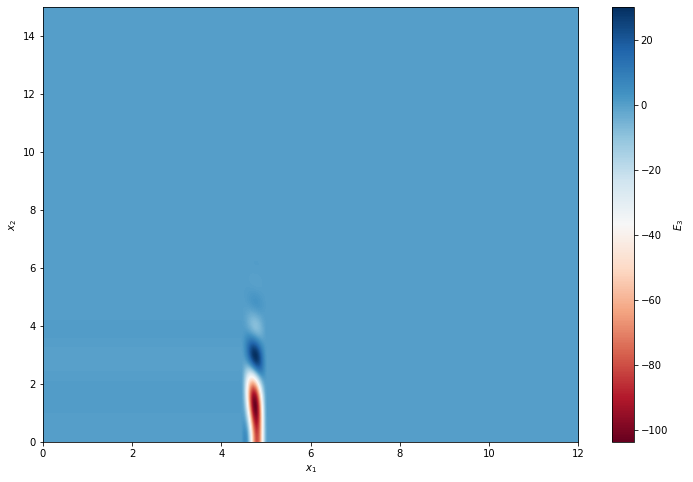

In [9]:
import matplotlib.pyplot as plt

boundary = [[0,sim.box[0]],[0,sim.box[1]]]

plt.imshow( ezs[0], interpolation = 'bilinear', origin = 'lower',
          extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
          aspect = 'auto', cmap = 'RdBu')

plt.colorbar().set_label('$E_3$')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
# plt.title("Laser Field\nt = {:g}".format(sim.t))

plt.show()

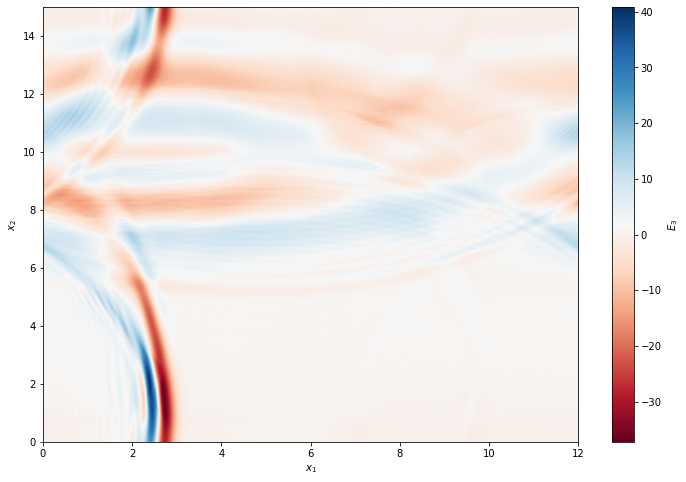

In [35]:
import matplotlib.pyplot as plt

boundary = [[0,sim.box[0]],[0,sim.box[1]]]

plt.imshow( ezs[10], interpolation = 'bilinear', origin = 'lower',
          extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
          aspect = 'auto', cmap = 'RdBu')

plt.colorbar().set_label('$E_3$')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
# plt.title("Laser Field\nt = {:g}".format(sim.t))

plt.show()

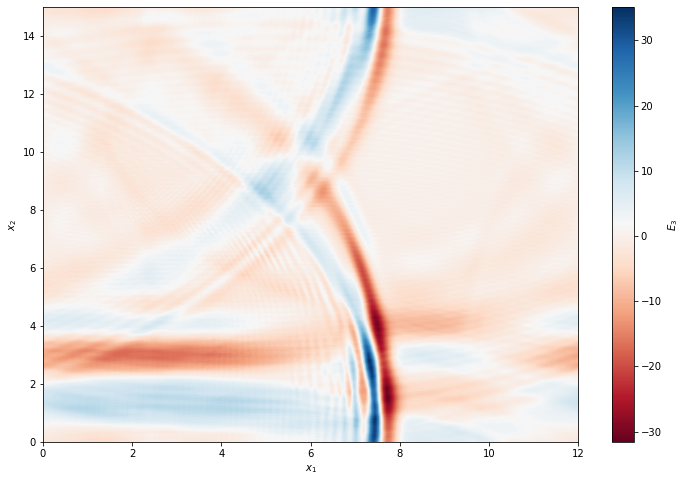

In [37]:
import matplotlib.pyplot as plt

boundary = [[0,sim.box[0]],[0,sim.box[1]]]

plt.imshow( ezs[15], interpolation = 'bilinear', origin = 'lower',
          extent = ( boundary[0][0], boundary[0][1], boundary[1][0], boundary[1][1] ),
          aspect = 'auto', cmap = 'RdBu')

plt.colorbar().set_label('$E_3$')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
# plt.title("Laser Field\nt = {:g}".format(sim.t))

plt.show()